# **Task 1: Feature Engineering + Deep Neural Network**

## **Step 1: Install and Import Required Libraries**

In [ ]:
!pip install pandas numpy scikit-learn whois nltk tensorflow torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 114.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
# === Import Required Libraries ===

import pandas as pd                 # For handling tabular data (loading CSV, feature columns)
import numpy as np                  # Useful for numerical operations and arrays
import torch                        # Main library for PyTorch tensor operations
import torch.nn as nn               # Contains classes to define neural network layers
import torch.optim as optim         # Provides optimization algorithms like Adam
import re                           # Used for pattern matching (e.g., detecting IP addresses)
import whois                        # Library to query domain registration information (for domain age)
import datetime                     # To calculate how old a domain is
import matplotlib.pyplot as plt     # For plotting loss curves (to monitor training progress)
from urllib.parse import urlparse   # Helps extract the domain part of a URL
from sklearn.preprocessing import StandardScaler  # To normalize features to same scale
from sklearn.model_selection import train_test_split  # To split dataset into train/test sets
from sklearn.metrics import accuracy_score  # To calculate final accuracy of the model


## **Step 2: Load the Dataset**

In [ ]:
# === Step 1: Load the phishing URL dataset ===

df = pd.read_csv('phishing_site_urls.csv')  # Loads the dataset which has two columns: 'URL' and 'Label'
print(df.head())  # Shows first few rows to verify structure (URLs + labels like 'good' or 'bad')

# Add this line to drop rows with NaN in the 'Label' column
df.dropna(subset=['Label'], inplace=True)


                                                 URL Label
0  nobell.it/70ffb52d079109dca5664cce6f317373782/...   bad
1  www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...   bad
2  serviciosbys.com/paypal.cgi.bin.get-into.herf....   bad
3  mail.printakid.com/www.online.americanexpress....   bad
4  thewhiskeydregs.com/wp-content/themes/widescre...   bad


## **Step 3: Feature Engineering**

In [ ]:
def has_ip_address(url):
    # Returns 1 if URL contains an IP address; 0 otherwise.
    # WHY: Phishing URLs often use IPs to avoid detection by domain filters.
    return 1 if re.match(r'\d+\.\d+\.\d+\.\d+', url) else 0


In [ ]:
def count_dots(url):
    # Returns the number of dots in the URL.
    # WHY: Phishing sites often use subdomains to mimic legit sites (like login.secure.paypal.fake.com).
    return url.count('.')


In [ ]:
def url_length(url):
    # Returns length of URL string.
    # WHY: Long URLs can be suspicious — attackers add noise to hide malicious content.
    return len(url)


In [ ]:
def domain_age(url):
    # Calculates how old a domain is in years based on WHOIS lookup.
    # WHY: Legitimate websites are usually older; phishing domains are created recently.
    try:
        domain_info = whois.whois(urlparse(url).netloc)  # Extract domain and look up WHOIS
        creation_date = domain_info.creation_date
        if isinstance(creation_date, list):  # Sometimes it's a list
            creation_date = creation_date[0]
        age = (datetime.datetime.now() - creation_date).days / 365  # Convert days to years
        return max(age, 0)  # Ensure non-negative
    except:
        return 0  # If WHOIS lookup fails (likely suspicious), assume age 0


In [ ]:
def has_redirection(url):
    # Checks for presence of redirection ('//') after the protocol.
    # WHY: Phishing URLs may use redirection to forward to malicious sites.
    return 1 if '//' in url[7:] else 0  # Skip 'http://'


In [ ]:
def contains_javascript(url):
    # Returns 1 if 'javascript' keyword is found.
    # WHY: URLs containing JavaScript may execute malicious code.
    return 1 if "javascript" in url.lower() else 0


In [ ]:
def count_special_chars(url):
    # Counts special characters like @, %, #, etc.
    # WHY: Phishing URLs often use obfuscation via special characters.
    return len(re.findall(r'[@!#$%^&*()<>?/|}{~:]', url))


## **Step 4: Apply Feature Extractions to Dataset**

In [ ]:
df['has_ip'] = df['URL'].apply(has_ip_address)
df['dot_count'] = df['URL'].apply(count_dots)
df['url_length'] = df['URL'].apply(url_length)
df['domain_age'] = df['URL'].apply(domain_age)
df['contains_javascript'] = df['URL'].apply(contains_javascript)
df['has_redirection'] = df['URL'].apply(has_redirection)
df['special_char_count'] = df['URL'].apply(count_special_chars)

# WHY: We’re creating 7 new numerical features that help identify phishing characteristics.


In [ ]:
df = df.drop(columns=['URL'])  # Drop the original text column since we now have numerical features

df['Label'] = df['Label'].map({'good': 0, 'bad': 1})  # Convert labels to binary (0=legit, 1=phishing)
# WHY: Neural networks work with numbers, not text labels


## **Step 5: Prepare Data for Neural Network**

In [ ]:
features = ['has_ip', 'dot_count', 'url_length', 'domain_age',
            'contains_javascript', 'has_redirection', 'special_char_count']
X = df[features].values  # Input features
y = df['Label'].values   # Target labels


In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
# WHY: Feature normalization helps training — ensures all features have similar range (mean=0, std=1),
# which leads to faster convergence and prevents one feature from dominating.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
# WHY: We split data into 80% training and 20% testing to evaluate model generalization.


In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
# WHY: PyTorch models need tensors as input. `unsqueeze(1)` reshapes y to be a column vector.


## **Step 6: Define Deep Neural Network**

In [ ]:
class PhishingDNN(nn.Module):
    def __init__(self, input_dim):
        super(PhishingDNN, self).__init__()

        self.fc1 = nn.Linear(input_dim, 16)  # Layer 1: Fully connected input → 16
        self.bn1 = nn.BatchNorm1d(16)        # Normalize layer outputs (helps convergence)
        self.relu1 = nn.LeakyReLU(0.01)      # Activation to avoid dead neurons

        self.fc2 = nn.Linear(16, 8)          # Layer 2: 16 → 8
        self.bn2 = nn.BatchNorm1d(8)
        self.relu2 = nn.LeakyReLU(0.01)

        self.fc3 = nn.Linear(8, 1)           # Output layer: 8 → 1
        self.sigmoid = nn.Sigmoid()         # Outputs probability between 0 and 1

    def forward(self, x):
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.relu2(self.bn2(self.fc2(x)))
        x = self.sigmoid(self.fc3(x))       # Final prediction
        return x

#📌 WHY DNN?
#Learns complex non-linear relationships between features and labels.
#Multiple layers help capture patterns that shallow models (like logistic regression) might miss.

## **Step 7: Train the Neural Network**

In [ ]:
model = PhishingDNN(input_dim=X_train.shape[1])  # Initialize model with 7 input features

criterion = nn.BCELoss()  # Loss function for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer adjusts learning rate automatically


In [ ]:
epochs = 500
train_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)  # Forward pass
    loss = criterion(outputs, y_train_tensor)  # Compute loss between prediction and true labels
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    train_losses.append(loss.item())  # Save loss for plotting

    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

#📌 WHY 500 Epochs?
#More epochs help the model converge properly.
#Printing every 10 steps helps monitor training progress without flooding logs.


Epoch 1/500, Loss: 0.709954
Epoch 11/500, Loss: 0.676167
Epoch 21/500, Loss: 0.653408
Epoch 31/500, Loss: 0.635290
Epoch 41/500, Loss: 0.619376
Epoch 51/500, Loss: 0.604757
Epoch 61/500, Loss: 0.591228
Epoch 71/500, Loss: 0.578624
Epoch 81/500, Loss: 0.566929
Epoch 91/500, Loss: 0.556277
Epoch 101/500, Loss: 0.546942
Epoch 111/500, Loss: 0.538769
Epoch 121/500, Loss: 0.531415
Epoch 131/500, Loss: 0.525045
Epoch 141/500, Loss: 0.519705
Epoch 151/500, Loss: 0.515291
Epoch 161/500, Loss: 0.511707
Epoch 171/500, Loss: 0.508793
Epoch 181/500, Loss: 0.506388
Epoch 191/500, Loss: 0.504512
Epoch 201/500, Loss: 0.503019
Epoch 211/500, Loss: 0.501726
Epoch 221/500, Loss: 0.500551
Epoch 231/500, Loss: 0.499563
Epoch 241/500, Loss: 0.498771
Epoch 251/500, Loss: 0.498124
Epoch 261/500, Loss: 0.497550
Epoch 271/500, Loss: 0.497019
Epoch 281/500, Loss: 0.496510
Epoch 291/500, Loss: 0.496027
Epoch 301/500, Loss: 0.495576
Epoch 311/500, Loss: 0.495153
Epoch 321/500, Loss: 0.494764
Epoch 331/500, Loss: 

## **Step 8: Evaluate the Model**

In [ ]:
model.eval()  # Switch to evaluation mode (disables batchnorm/dropout randomness)
with torch.no_grad():  # Disable gradient tracking for faster inference
    y_pred = model(X_test_tensor)
    y_pred = (y_pred > 0.5).int()  # Convert probability to class (0 or 1)
accuracy = accuracy_score(y_test, y_pred.numpy())  # Compare predictions with true labels
print(f"DNN Model Accuracy: {accuracy * 100:.2f}%")
# WHY: Accuracy gives overall effectiveness of model on unseen test data

DNN Model Accuracy: 77.95%


## **Step 9: Plot the Training Loss Curve**

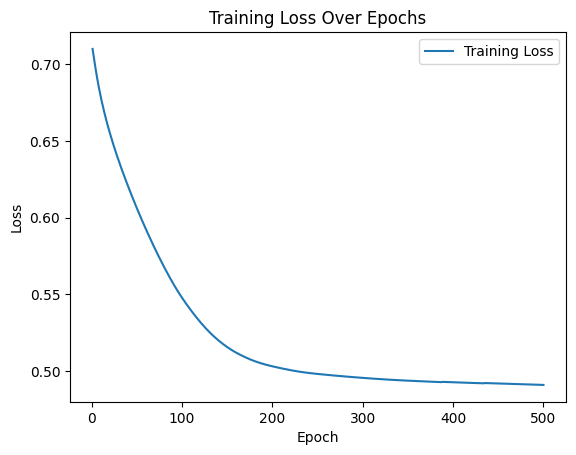

In [ ]:
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()
# WHY: Visual feedback — ensures the model is learning (loss should go down)
